In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(
    style="whitegrid",  # ('darkgrid', 'whitegrid', 'dark', 'white', 'ticks')
    # palette="deep",   # Optional: set a default color palette
    # context="notebook", # Optional: scale elements ('paper', 'notebook', 'talk', 'poster')
    rc={
        'figure.figsize': (10, 6),
        'axes.titlesize': 14,
        'axes.labelsize': 12,
    }
)

In [3]:
df_people = pd.read_csv('data/People.csv', index_col=0, encoding='ISO-8859-1')
df_team = pd.read_csv('data/Teams.csv', index_col=0, encoding='ISO-8859-1')
df_batting = pd.read_csv('data/Batting.csv', index_col=0, encoding='ISO-8859-1')
df_pitching = pd.read_csv('data/Pitching.csv', index_col=0, encoding='ISO-8859-1')

In [4]:
df_pitching.loc['ohtansh01', ['yearID', 'W', 'L', 'G', 'SO', 'R', 'H', 'ER', 'HR', 'BB', 'ERA', 'BAOpp']]

,yearID,W,L,G,SO,R,H,ER,HR,BB,ERA,BAOpp
playerID,,,,,,,,,,,,
ohtansh01,2018,4,2,10,63,19,38,19,6,22,3.31,0.203
ohtansh01,2020,0,1,2,3,7,3,7,0,8,37.80,0.375
ohtansh01,2021,9,2,23,156,48,98,46,15,44,3.18,0.207
ohtansh01,2022,15,9,28,219,45,124,43,14,44,2.33,0.203
ohtansh01,2023,10,5,23,167,50,85,46,18,55,3.14,0.184


In [5]:
df_batting.loc['ohtansh01', ['yearID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SO']]

,yearID,G,AB,R,H,2B,3B,HR,RBI,SO
playerID,,,,,,,,,,
ohtansh01,2018,114,326,59,93,21,2,22,61.0,102.0
ohtansh01,2019,106,384,51,110,20,5,18,62.0,110.0
ohtansh01,2020,46,153,23,29,6,0,7,24.0,50.0
ohtansh01,2021,158,537,103,138,26,8,46,100.0,189.0
ohtansh01,2022,157,586,90,160,30,6,34,95.0,161.0
ohtansh01,2023,135,497,102,151,26,8,44,95.0,143.0


### Player Analysis

In [6]:
df_people = pd.read_csv('data/People.csv', index_col=0, encoding='ISO-8859-1')

In [7]:
df_people = (
   df_people
   .astype({
         'debut': 'datetime64[ns]',
         'finalGame': 'datetime64[ns]'
      })
   .assign(
      birthDate=lambda df_: pd.to_datetime({
         'year': df_['birthYear'],
         'month': df_['birthMonth'],
         'day': df_['birthDay']
      }),
      debutYear=lambda df_: df_['debut'].dt.year.astype('Int64'),
      isBirthCountryUSA=lambda df_: df_.apply(lambda row: 'Yes' if row['birthCountry'] == 'USA' else 'No', axis=1),
      nameFull=lambda df_: df_['nameFirst'] + " " + df_['nameLast']
   )
   .loc[:, ['playerID', 'nameFull', 'weight', 'height', 'birthCountry', 'isBirthCountryUSA', 'birthDate', 'debut', 'debutYear', 'finalGame']]
   #.sample(3)
   #.info()
   #.pipe(lambda df_: df_[df_['debut'].isna()])
   #.debutYear.value_counts().sort_index().plot(kind='bar')
)

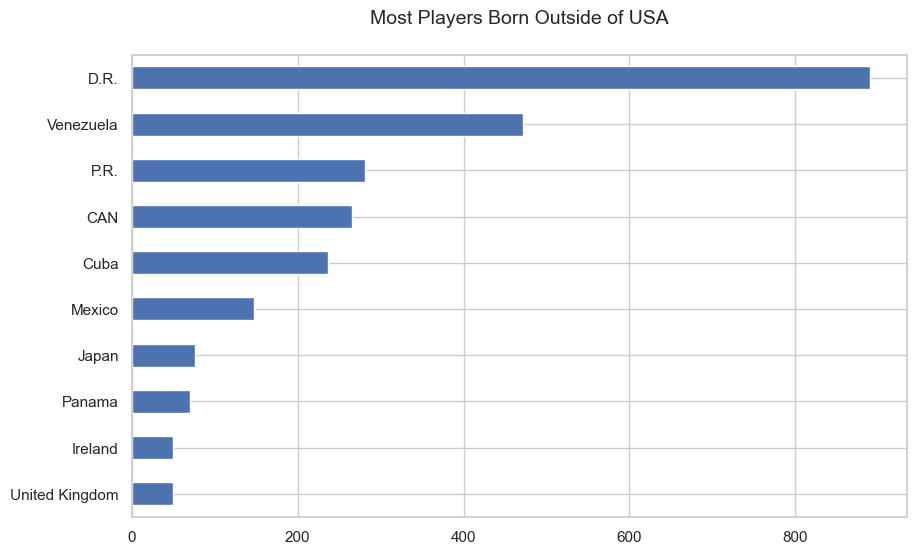

In [8]:
(
    df_people
    .pipe(lambda df_: df_[df_['isBirthCountryUSA'] == 'No'])
    .birthCountry.value_counts()
    .head(10)
    .sort_values()
    .plot(kind='barh')
)

plt.ylabel('')
plt.title('Most Players Born Outside of USA', y=1.05)
plt.show()

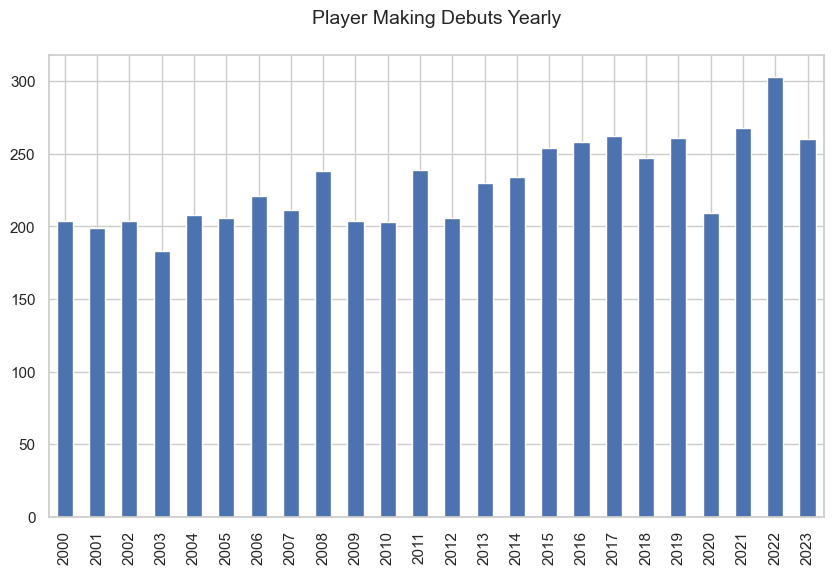

In [9]:
(
    df_people
    .pipe(lambda df_: df_[df_['debutYear'] >= 2000])
    .debutYear.value_counts()
    .sort_index()
    .plot(kind='bar')
)

plt.xlabel('')
plt.title('Player Making Debuts Yearly', y=1.05)
plt.show()

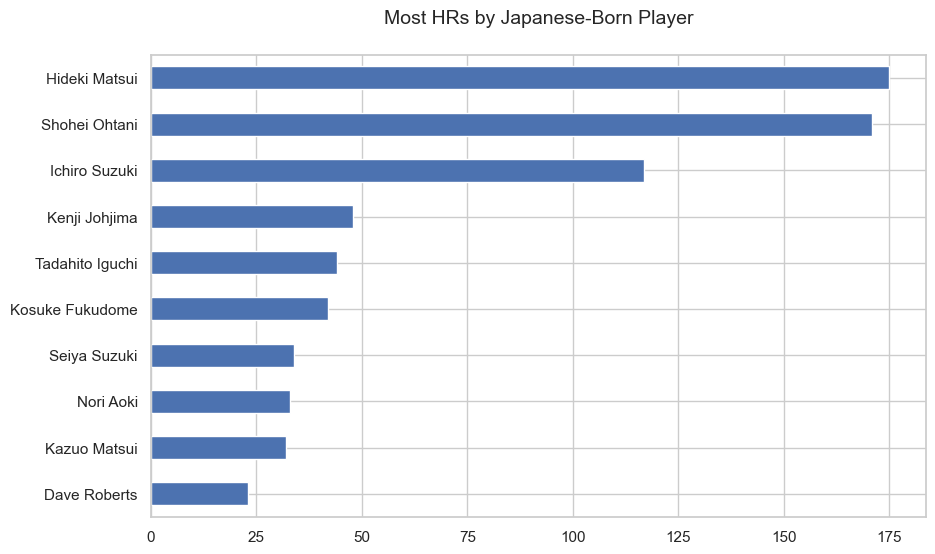

In [10]:
(
    df_people
    .pipe(lambda df_: df_[df_['birthCountry'] == 'Japan'])
    .join(df_batting, how='inner', on='playerID')
    .loc[:, ['playerID', 'nameFull', 'yearID', 'HR']]
    .groupby('nameFull')['HR'].sum().sort_values(ascending=False)
    .head(10).sort_values()
    .plot(kind='barh')
)

plt.ylabel('')
plt.title('Most HRs by Japanese-Born Player', y=1.05)
plt.show()

In [11]:
(
    df_people
    .join(df_pitching, how='inner', on='playerID')
    .loc[:, ['playerID', 'nameFull', 'yearID', 'CG', 'SHO', 'G']]
    .groupby('nameFull')
    .agg(
        total_complete_games = ('CG', 'sum'),
        total_shutouts = ('SHO', 'sum'),
        total_games = ('G', 'sum'),
    )
    .sort_values(by='total_shutouts', ascending=False)
    #.head(10).sort_values()
    #.plot(kind='barh')
)

,total_complete_games,total_shutouts,total_games
nameFull,,,
Walter Johnson,531,110,802
Pete Alexander,437,90,696
Christy Mathewson,435,79,636
Cy Young,749,76,906
Eddie Plank,410,69,623
...,...,...,...
George Craig,0,0,2
George Crable,1,0,2
George Cox,0,0,26


In [12]:
complete = (
    df_people
    .join(df_pitching, how='inner', on='playerID')
    .loc[:, ['nameFull', 'CG']]
    .groupby('nameFull')['CG']
    .sum()
    .nlargest(10)
    .sort_values()
    .to_frame()
    .rename(columns={'CG': 'total_complete_games'})
)

shutout = (
    df_people
    .join(df_pitching, how='inner', on='playerID')
    .loc[:, ['nameFull', 'SHO']]
    .groupby('nameFull')['SHO']
    .sum()
    .nlargest(10)
    .sort_values()
    .to_frame()
    .rename(columns={'SHO': 'total_shutout_games'})
)

# Find Common Player
common_players = complete.index.intersection(shutout.index)

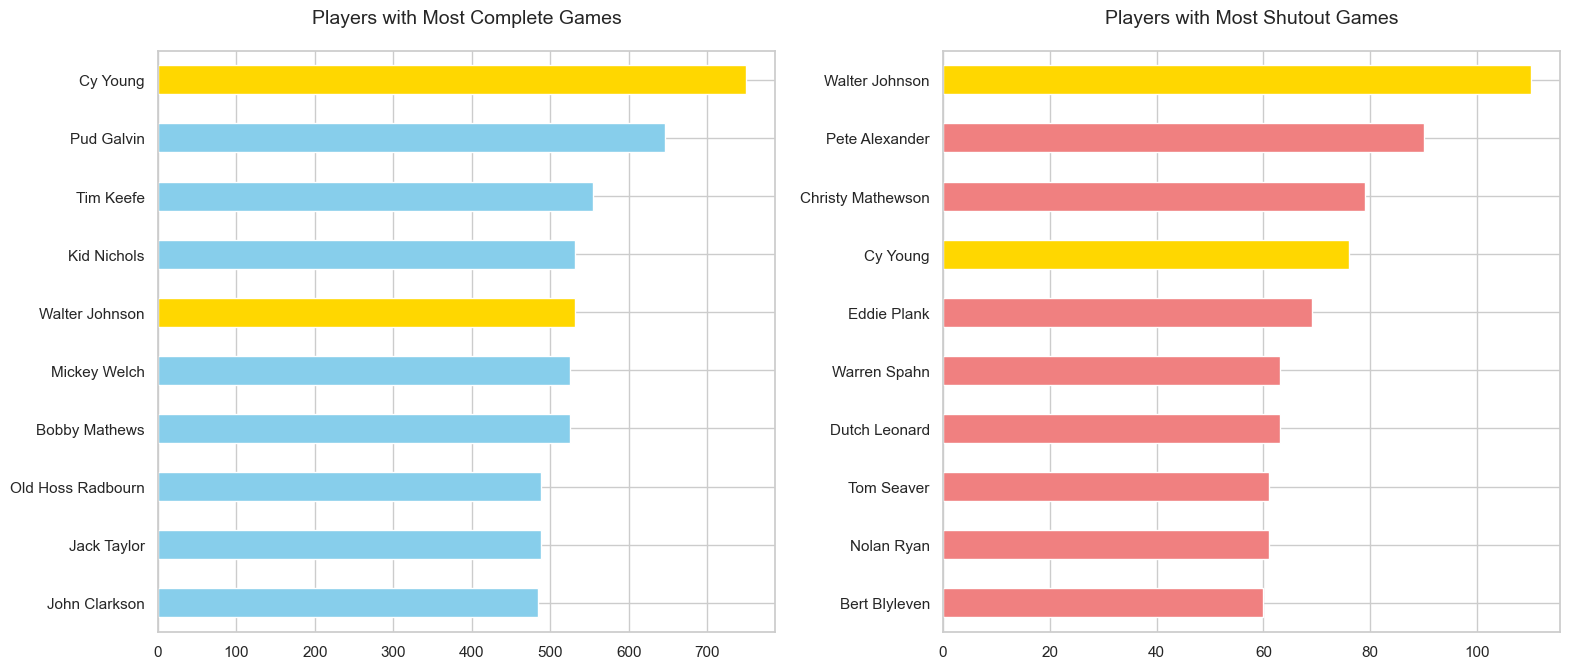

In [13]:
highlight_color = 'gold'
base_color_cg = 'skyblue'
base_color_sho = 'lightcoral'

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

complete.plot(kind='barh', ax=ax1, color=base_color_cg, legend=False)
ax1.set_title('Players with Most Complete Games', pad=20)
ax1.set_ylabel('')

shutout.plot(kind='barh', ax=ax2, color=base_color_sho, legend=False)
ax2.set_title('Players with Most Shutout Games', pad=20)
ax2.set_ylabel('')

for patch, player_name in zip(ax1.patches, complete.index):
    if player_name in common_players:
        patch.set_facecolor(highlight_color)

for patch, player_name in zip(ax2.patches, shutout.index):
    if player_name in common_players:
        patch.set_facecolor(highlight_color)

plt.tight_layout(pad=1.5)
plt.show()